# Decision Trees

This notebook implements a decision tree algorithm for classification to showcase the utility and functionality **of the written decision tree algorithm**. For a description of the algorithm **and the background**, see **this README**.

The notebook is separated into several sections, each containing **separate aspects of the data analysis/data preprocessing process**. They are **as follows**

### Library Imports
This section imports the libraries **and modules** required to run the decision tree algorithm. The **following dependencies are required**

In [288]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from rice_ml.preprocess import *
from rice_ml.supervised_learning.decisiontrees import *
from rice_ml.postprocess.classificationpost import *

### Data Loading & Cleaning
The data used in this notebook comes from Palmer Penguins, a common toy dataset for evaluating classification algorithms due to its **clear-cut features/simplicity/not too large/other benefits**. It has been chosen **because it is simple for classification** and requires several preprocessing steps, including **handling missing values**, which **showcase the preprocessing modules/package**. This dataset contains the following feature data for 344 penguins:
- Species: **fill this in, three species - 'Adelie' 'Chinstrap' 'Gentoo'**
- Island: **fill this in - 'Biscoe' 'Dream' 'Torgersen'**
- Bill Length (mm): continuous values, measuring bill length in millimeters
- Bill Depth (mm): continuous values, measuring bill depth in millimeters
- Flipper Length (mm): continuous values, measuring flipper length in millimeters
- Body Mass (g): continuous values, measuring body mass in grams
- Sex: **binary male/female**

**we drop some features** 
**This section covers the actual loading of the data; the data is loaded using `sns.load_dataset("penguins")`. Explanation here!! why those features?? encode using pandas uniques. Then cleaned using preprocessing - dropped missing values, identified outliers with z-scoring and dropped, dropped duplicates, z-scored the feature data for standardization**. This **notebook attempts to predict species. This section is copied in KNN as well, given that they use very similar algorithms**

In [289]:
# Loading the basic dataset and selecting features
penguins_df = sns.load_dataset("penguins")
penguin_features = penguins_df[[
    "species", 
    "bill_length_mm", 
    "bill_depth_mm", 
    "flipper_length_mm", 
    "body_mass_g"
]]
penguin_features.loc[:, 'species'], uniques = pd.factorize(penguin_features['species'])
display(penguin_features)

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,0,39.1,18.7,181.0,3750.0
1,0,39.5,17.4,186.0,3800.0
2,0,40.3,18.0,195.0,3250.0
3,0,NaN,NaN,NaN,NaN
4,0,36.7,19.3,193.0,3450.0
...,...,...,...,...,...
339,2,NaN,NaN,NaN,NaN
340,2,46.8,14.3,215.0,4850.0
341,2,50.4,15.7,222.0,5750.0
342,2,45.2,14.8,212.0,5200.0


The dataset contains **some missing values (e.g., row 4)** and **may contain outliers or duplicates**. To **put the data in a usable format**, we apply a series of preprocessing **algorithms**, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another.

In [290]:
# Cleaning the dataset (dropping rows with missing values, duplicates, or containing outliers)
penguin_features_cleaned_missing = missing_data(penguin_features, 'drop')
penguin_features_cleaned_outliers = outlier_identify(penguin_features_cleaned_missing, 'zscore', drop = True)
penguin_features_cleaned = duplicate_identify(penguin_features_cleaned_outliers, True)
print(f"Cleaned data (first five rows): \n {penguin_features_cleaned[0:5, :]}")

Cleaned data (first five rows): 
 [[   0.    39.1   18.7  181.  3750. ]
 [   0.    39.5   17.4  186.  3800. ]
 [   0.    40.3   18.   195.  3250. ]
 [   0.    36.7   19.3  193.  3450. ]
 [   0.    39.3   20.6  190.  3650. ]]


Two rows have been removed during cleaning, and the dataset no longer contains NaN values. For use in KNN classification and **for ease of visualization**, the dataset must be split into the target feature (species) and the remaining **features**.

In [291]:
# Creating two arrays
penguin_species = penguin_features_cleaned[:, 0]
penguin_feature_data = penguin_features_cleaned[:, 1:]
print(f"Array for penguin species (first five entries): \n {penguin_species[0:5]} \n \n \
Array for penguin feature data (first five rows): \n {penguin_feature_data[0:5]}")

Array for penguin species (first five entries): 
 [0. 0. 0. 0. 0.] 
 
 Array for penguin feature data (first five rows): 
 [[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 [  36.7   19.3  193.  3450. ]
 [  39.3   20.6  190.  3650. ]]


### Data Visualization

**Once the data has been cleaned, this section contains version of visualizing data (correlations, plotting two features for classification). for decision trees with two features, we will use bill length and body mass, since KNN uses a different set of features and the goal is to see if something is different.** **the first step is using the correlation matrix to be able to see what features may be** appropriate for classifying species type.

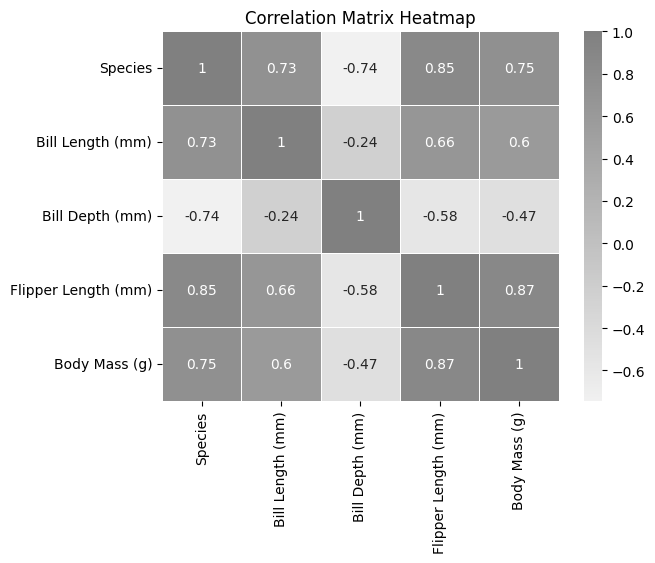

In [292]:
# Creating and plotting a correlation matrix with a heatmap
correlation_matrix = (pd.DataFrame(penguin_features_cleaned, columns = ['Species', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'])).corr()
sns.heatmap(correlation_matrix, annot = True, cmap = sns.light_palette('gray', as_cmap=True), linewidths = 0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Both bill length and body mass appear to be correlated with species (0.85 and 0.75, respectively). Consequently, these features are **appropriate for KNN and we will use these moving forward until [the later section]**. To visualize the relationship between the three variables and **identify possible clusters**, we create a 2D plot of bill depth versus bill length, with colors indicating species. **they also do not overlap with what was used in KNN**

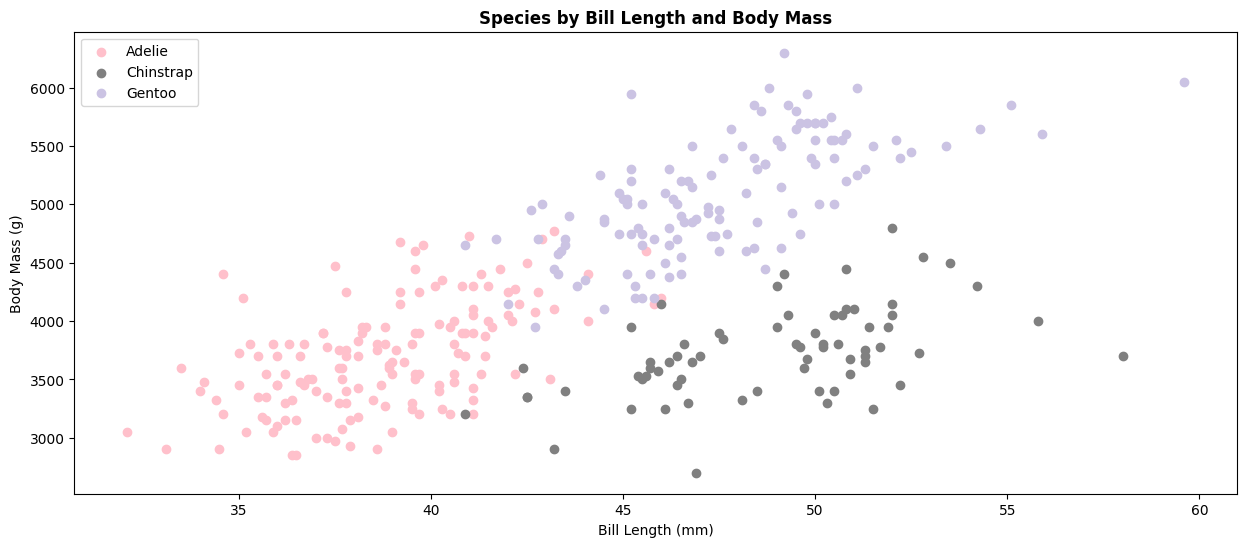

In [293]:
# Plotting bill length and body mass, color-coded by species
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}

plt.figure(figsize = (15, 6))
for species in np.unique(penguin_species):
    mask = (penguin_species == species)
    plt.scatter(penguin_feature_data[mask, 0], penguin_feature_data[mask, 3], label = species, color = colors[species])
    
plt.legend(['Adelie', 'Chinstrap', 'Gentoo'])
plt.title("Species by Bill Length and Body Mass", fontweight = 'bold')
plt.xlabel("Bill Length (mm)")
plt.ylabel("Body Mass (g)")

plt.show()

Three separate clusters for each species appear **from this plot**, **meaning that we can use this for decision trees. elaborate!!**

### Decision Tree Implementation (2 Features)

This section **implements a basic decision tree algorithm for the two identified features to attempt to classify species**. **elaborate!!** 

**To avoid skewing results with different feature values**, we standardize the feature data **by calculating zscores** using the `z_score_standardize` **module** from the preprocessing package. This ensures that **no feature dominates/overrides the other ones** by **making them all the same scale**. The z-score equation used is **this!!**

In [294]:
# Standardizing the features
penguin_feature_data_normal = z_score_standardize(penguin_feature_data[:, [0, 3]])
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874 -0.56414208]
 [-0.81112573 -0.50170305]
 [-0.66437972 -1.18853234]
 [-1.32473679 -0.93877623]
 [-0.84781224 -0.68902013]]


In [295]:
# Splitting the data into training and testing arrays
train_array, test_array, train_targets, test_targets = train_test(penguin_feature_data_normal, penguin_species, stratify = penguin_species)

# Verifying sizes of each array
print(f"Shape of training array: {train_array.shape}")
print(f"Shape of training targets: {train_targets.shape}")
print(f"Shape of testing array: {test_array.shape}")
print(f"Shape of testing targets: {test_targets.shape}")

Shape of training array: (240, 2)
Shape of training targets: (240,)
Shape of testing array: (102, 2)
Shape of testing targets: (102,)


Once the data has been scaled, it is split into testing and training arrays. This ensures that the model is not trained and tested on the same set of data, allowing for unbiased evaluation of model performance and preventing overfitting. **stratification/0.3 test_array size**. There are 342 samples in **the cleaned dataset**, so the training array should have 240 samples and the testing should have 102.

In [296]:
# Splitting the data into training and testing arrays
train_array, test_array, train_targets, test_targets = train_test(penguin_feature_data_normal, penguin_species, stratify = penguin_species)

# Verifying sizes of each array
print(f"Shape of training array: {train_array.shape}")
print(f"Shape of training targets: {train_targets.shape}")
print(f"Shape of testing array: {test_array.shape}")
print(f"Shape of testing targets: {test_targets.shape}")

Shape of training array: (240, 2)
Shape of training targets: (240,)
Shape of testing array: (102, 2)
Shape of testing targets: (102,)


**Next, we apply a decision tree by initializing a `decision_tree` class from the supervised learning package, and fitting it on the training data**. The test feature data is then **fed into** the fit model to predict species labels **from previously unseen data**. **model specifications**

In [297]:
# Fitting the model
tree = decision_tree()
tree.fit(train_array, train_targets)

# Predicting species based on testing data
prediction = tree.predict(test_array)

**When the model has been successfully called/fit, we calculate a variety of postprocessing/accuracy/scoring metrics using the postprocessing package**. These include **accuracy, a visualization of the confusion matrix, and precision/recall/f1 scores for each one**. **fix this!! plot with the scores**. The **plot below shows the classification for the test cases plotted against the correct labels for the entire dataset; the rightmost plot contains the same plots/labels, but with the incorrectly classified points labeled in yellow.**

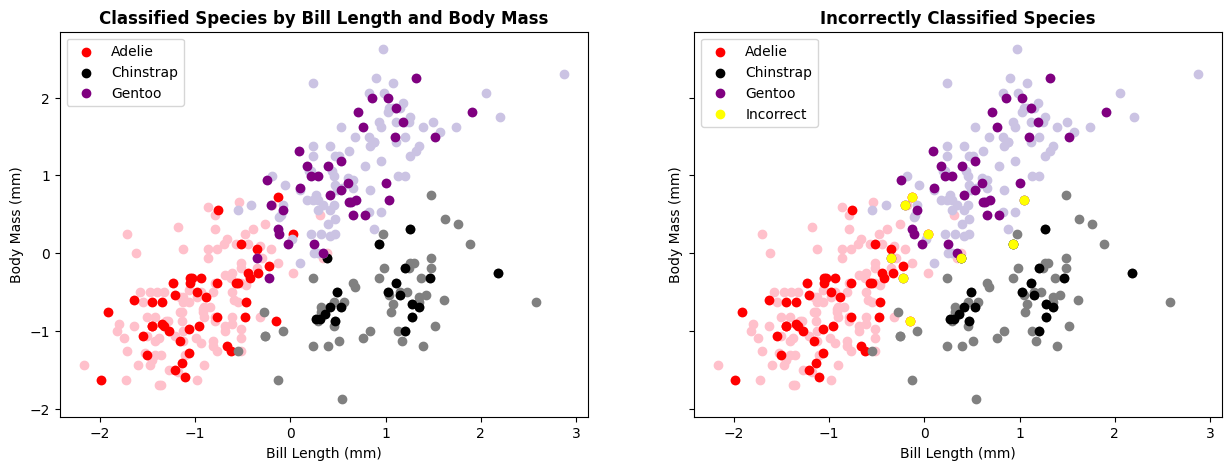

In [298]:
# Plotting bill length and body mass, color-coded by species
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}
colors_2 = {0: 'red', 1: 'black', 2: 'purple'}

fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharex = True, sharey = True)

for species in np.unique(penguin_species):
    mask = (penguin_species == species)
    ax[0].scatter(penguin_feature_data_normal[mask, 0], penguin_feature_data_normal[mask, 1], label = species, color = colors[species])
    ax[1].scatter(penguin_feature_data_normal[mask, 0], penguin_feature_data_normal[mask, 1], label = species, color = colors[species])
    mask_new = (test_targets == species)
    ax[0].scatter(test_array[mask_new, 0], test_array[mask_new, 1], label = species, color = colors_2[species])
    ax[1].scatter(test_array[mask_new, 0], test_array[mask_new, 1], label = species, color = colors_2[species])

mask_incorrect = (test_targets != prediction)
ax[1].scatter(test_array[mask_incorrect, 0], test_array[mask_incorrect, 1], label = species, color = 'yellow')

handles, labels = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in [1, 3, 5]]
selected_handles_2 = [handles[i] for i in [1, 3, 5, 6]]
ax[0].legend(handles = selected_handles, labels = ['Adelie', 'Chinstrap', 'Gentoo'])
ax[1].legend(handles = selected_handles_2, labels = ['Adelie', 'Chinstrap', 'Gentoo', 'Incorrect'])

ax[0].set_title("Classified Species by Bill Length and Body Mass", fontweight = 'bold')
ax[1].set_title("Incorrectly Classified Species", fontweight = 'bold')

for i in range(2):
    ax[i].set_xlabel("Bill Length (mm)")
    ax[i].set_ylabel("Body Mass (mm)")

plt.show()

The decision tree itself can be visualized to determine what feature values **decide splits**, and the boundaries of the tree can be plotted to demonstrate **the decision process**

In [299]:
# Printing the decision tree
tree.print_tree()

Feature 0 <= -0.28834304997708105
	Feature 1 <= 0.5285408780592884
		Feature 0 <= -0.5634918309261927
			Predict: 0
			Feature 0 <= -0.5359769528312812
				Feature 1 <= -0.9387762331540106
					Predict: 1
					Predict: 0
				Predict: 0
		Feature 0 <= -0.7102378474323852
			Predict: 0
			Feature 1 <= 0.6378091735751724
				Predict: 2
				Predict: 0
	Feature 1 <= -0.03341035602240053
		Feature 1 <= -0.2831664600587067
			Predict: 1
			Feature 0 <= 0.6655060573131728
				Feature 0 <= 0.06935036525676469
					Predict: 0
					Feature 0 <= 0.22526800779459427
						Predict: 2
						Predict: 0
				Predict: 1
		Feature 1 <= 0.7782969820955946
			Feature 0 <= 0.9589980903255595
				Feature 0 <= -0.15076865950252522
					Predict: 0
					Feature 0 <= 0.2986410160476911
						Predict: 2
						Feature 0 <= 0.3903572763640617
							Feature 0 <= 0.3169842681109655
								Predict: 0
								Feature 0 <= 0.3628423982691501
									Predict: 2
									Predict: 0
							Predict: 2
				Predict: 1
			Pr

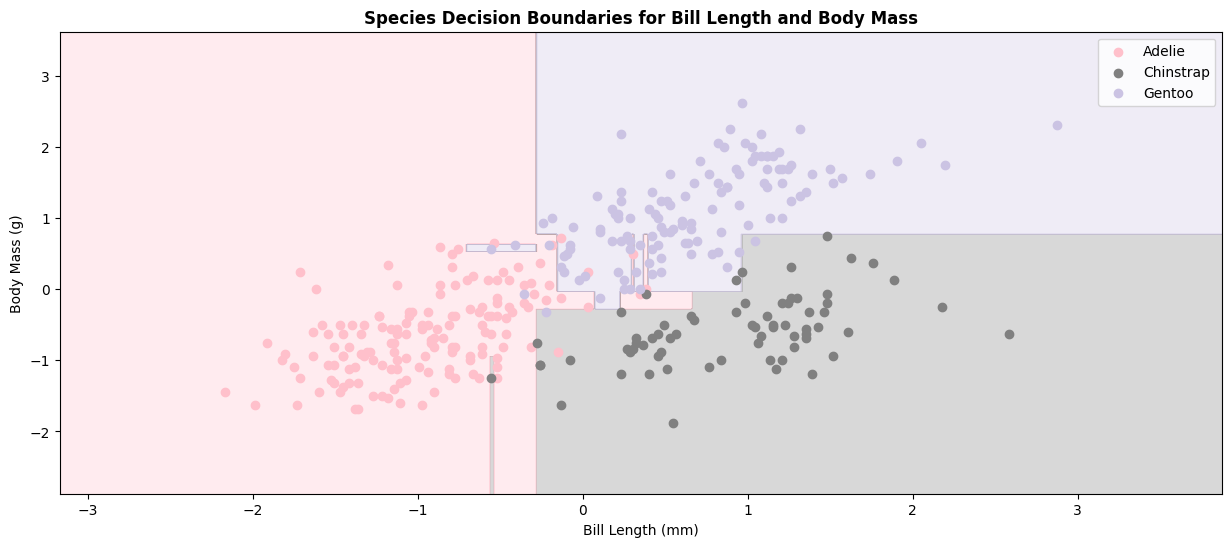

In [300]:
# Creating the meshgrid
x_min, x_max = penguin_feature_data_normal[:, 0].min() - 1, penguin_feature_data_normal[:, 0].max() + 1
y_min, y_max = penguin_feature_data_normal[:, 1].min() - 1, penguin_feature_data_normal[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid_points = np.c_[xx.ravel(), yy.ravel()]
meshgrid_prediction = tree.predict(grid_points)
meshgrid_prediction = np.array(meshgrid_prediction, dtype = int).reshape(xx.shape)

# Plotting the decision boundaries
plt.figure(figsize=(15, 6))
cmap = ListedColormap(['pink', 'gray', '#CBC3E3'])
plt.contourf(xx, yy, meshgrid_prediction, alpha = 0.3, cmap = cmap)
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}
for species in np.unique(penguin_species):
    mask = (penguin_species == species)
    plt.scatter(penguin_feature_data_normal[mask, 0], penguin_feature_data_normal[mask, 1], label = species, color = colors[species])
plt.xlabel('Bill Length (mm)')
plt.ylabel('Body Mass (g)')
plt.title('Species Decision Boundaries for Bill Length and Body Mass', fontweight = 'bold')
plt.legend(['Adelie', 'Chinstrap', 'Gentoo'])
plt.show()

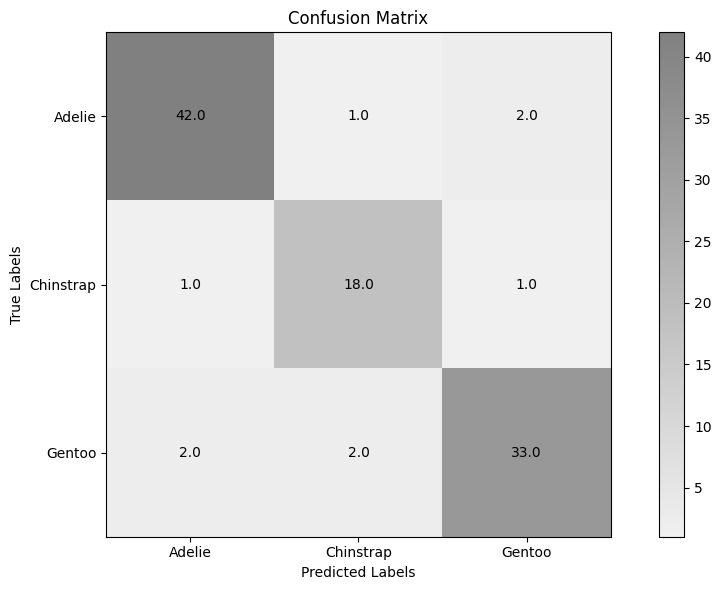

In [301]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(prediction, test_targets, conf_matrix_labels = ['Adelie', 'Chinstrap', 'Gentoo'])

In [302]:
# Evaluating model performance on various metrics
print_model_metrics(prediction, test_targets)

Model Metrics 
------------- 
Accuracy: 0.91 
Precision (Micro): 0.91 
Precision (Macro): 0.90 
Recall (Micro): 0.91 
Recall (Macro): 0.91 
F1 (Micro): 0.91 
F1 (Macro): 0.91


**TODO: interpretation of this!!**

### Decision Tree Implementation (Changing Parameters)

This section **implements a basic decision tree algorithm for the two identified features to attempt to classify species**, but **with different metrics (maximum depth and number of samples to split)**

In [ ]:
# Arrays for maximum depth and accuracy
max_depth_values = np.arange(1, 11)
accuracy_values_max_depth = np.full(len(max_depth_values), np.nan)

# Fitting and scoring the model for each maximum depth
for i in range(len(max_depth_values)):
    tree = decision_tree(max_depth = int(max_depth_values[i]))
    tree.fit(train_array, train_targets)
    prediction = tree.predict(test_array)
    accuracy = accuracy_score(prediction, test_targets)
    accuracy_values_max_depth[i] = accuracy

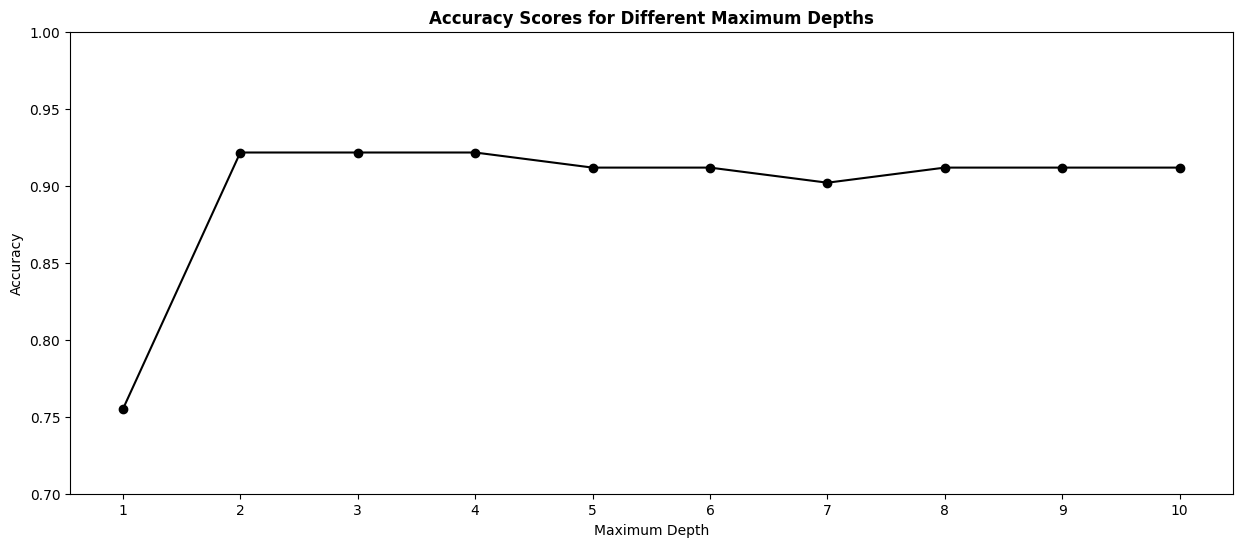

In [315]:
# Plotting the change in accuracy across different maximum depths
plt.figure(figsize = (15, 6))
plt.plot(max_depth_values, accuracy_values_max_depth, 'black')
plt.scatter(max_depth_values, accuracy_values_max_depth, color = 'black')
plt.title("Accuracy Scores for Different Maximum Depths", fontweight = 'bold')
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.xticks(range(1, 11))
plt.show()

**TODO: need an interpretation of this!!**

In [305]:
# Arrays for minimum samples to split
min_samples_values = np.arange(1, 11)
accuracy_values_min_samples = np.full(len(min_samples_values), np.nan)

# Fitting and scoring the model for each maximum depth
for i in range(len(min_samples_values)):
    tree = decision_tree(max_depth = int(min_samples_values[i]))
    tree.fit(train_array, train_targets)
    prediction = tree.predict(test_array)
    accuracy = accuracy_score(prediction, test_targets)
    accuracy_values_min_samples[i] = accuracy

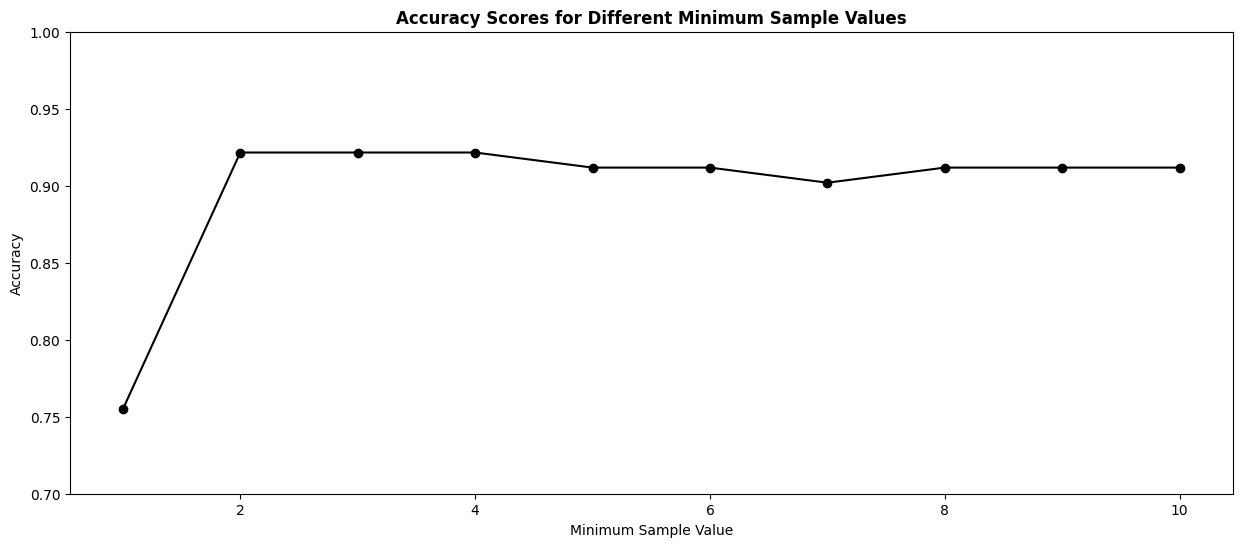

In [306]:
# Plotting the change in accuracy across different maximum depths
plt.figure(figsize = (15, 6))
plt.plot(min_samples_values, accuracy_values_min_samples, 'black')
plt.scatter(min_samples_values, accuracy_values_min_samples, color = 'black')
plt.title("Accuracy Scores for Different Minimum Sample Values", fontweight = 'bold')
plt.xlabel("Minimum Sample Value")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.show()

**TODO: need interpretation!!**

### Decision Tree Implementation (Multiple Features)

**this section implements a decision tree in the same way using multiple features to see if it improves model accuracy/works**. As before, we begin by standardizing all features and splitting the data into training and test sets, then **initializing/fitting a model**

In [307]:
# Standardizing the features
penguin_feature_data_normal_all_feat = z_score_standardize(penguin_feature_data)
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal_all_feat[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874  0.78544923 -1.41834665 -0.56414208]
 [-0.81112573  0.1261879  -1.06225022 -0.50170305]
 [-0.66437972  0.43046236 -0.42127665 -1.18853234]
 [-1.32473679  1.08972369 -0.56371522 -0.93877623]
 [-0.84781224  1.74898502 -0.77737308 -0.68902013]]


In [308]:
# Splitting the data into training and testing arrays
train_array_mult, test_array_mult, train_targets_mult, test_targets_mult = train_test(penguin_feature_data_normal_all_feat, penguin_species, stratify = penguin_species)

# Verifying sizes of each array
print(f"Shape of training array: {train_array_mult.shape}")
print(f"Shape of training targets: {train_targets_mult.shape}")
print(f"Shape of testing array: {test_array_mult.shape}")
print(f"Shape of testing targets: {test_targets_mult.shape}")

Shape of training array: (240, 4)
Shape of training targets: (240,)
Shape of testing array: (102, 4)
Shape of testing targets: (102,)


In [309]:
# Fitting the model
tree_mult = decision_tree()
tree_mult.fit(train_array_mult, train_targets_mult)

# Predicting species based on testing data
prediction_mult = tree_mult.predict(test_array_mult)

**We then evaluate across various performance metrics, and print the tree**. As seen below, this decision tree **is less than the previous ones, indicating clearer boundaries across the features for species classification**

In [310]:
# Printing the decision tree
tree_mult.print_tree()

Feature 2 <= 0.4689644184866296
	Feature 0 <= -0.14159703347088992
		Feature 0 <= -0.5634918309261951
			Predict: 0
			Feature 1 <= 0.12618789738684047
				Feature 2 <= -0.8485923647127092
					Predict: 1
					Predict: 0
				Predict: 0
		Feature 3 <= -0.033410356022400535
			Predict: 1
			Feature 0 <= 0.6013046750917109
				Predict: 0
				Feature 0 <= 0.8947967081040968
					Predict: 2
					Predict: 1
	Feature 1 <= 0.2529689223759706
		Predict: 2
		Feature 0 <= 0.4820735366804295
			Predict: 0
			Predict: 1


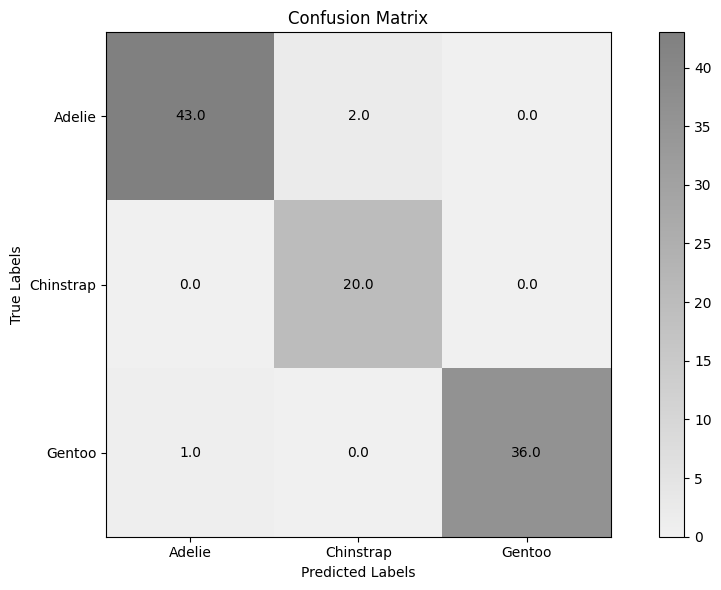

In [311]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(prediction_mult, test_targets_mult, conf_matrix_labels = ['Adelie', 'Chinstrap', 'Gentoo'])

In [312]:
# Evaluating model performance on various metrics
print_model_metrics(prediction_mult, test_targets_mult)

Model Metrics 
------------- 
Accuracy: 0.97 
Precision (Micro): 0.97 
Precision (Macro): 0.96 
Recall (Micro): 0.97 
Recall (Macro): 0.98 
F1 (Micro): 0.97 
F1 (Macro): 0.97


This model is much more accurate than the **model that only included bill length (?) and body mass**, indicating that **the inclusion of more features is beneficial in accuracy.**

### Comparison with Existing Models

**This section compares this decision tree, which was built in the supervised learning package**, with the **established models using SciKit Learn**. It **evaluates the model accuracy on the entire dataset**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_sk = DecisionTreeClassifier(max_depth = None, min_samples_split = 2)
tree_sk.fit(train_array_mult, train_targets_mult)
prediction_sk = tree_sk.predict(test_array_mult)

In [314]:
print_model_metrics(prediction_sk, test_targets_mult)

Model Metrics 
------------- 
Accuracy: 0.96 
Precision (Micro): 0.96 
Precision (Macro): 0.95 
Recall (Micro): 0.96 
Recall (Macro): 0.95 
F1 (Micro): 0.96 
F1 (Macro): 0.95


The decision tree from SciKit Learn **has essentially the same accuracy/other scores** as the **built model, showing that it is verified/reliable alongside existing metrics**. **TODO - finish this!!!**